# NAMA: FELIX PRATAMASAN
# EMAIL: felixpratama242@gmail.com



In [21]:
import tensorflow as tf
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from keras.callbacks import EarlyStopping
import seaborn as sns
import pathlib
%matplotlib inline

# Download Data

In [2]:
#you need to create your own API first in kaggle
#upload kaggle json

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"felixpratama","key":"a3f1e3c240e43be127334f9fe19c9a0e"}'}

In [3]:
#create a kaggle folder
!mkdir ~/.kaggle

In [4]:
#copy kaggle.json to folder created
!cp kaggle.json ~/.kaggle/

#permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification

 95% 329M/346M [00:03<00:00, 112MB/s]
100% 346M/346M [00:03<00:00, 91.0MB/s]


#Read Dataset

In [6]:
test_local_zip = '/content/intel-image-classification.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/content/dataset')

zip_ref.close()

In [7]:
train_dir = '/content/dataset/seg_train/seg_train'
# test_dir = '/content/dataset/seg_test/seg_test'

In [8]:
print('Num of classes: {}, there are: {}'.format(len(os.listdir(train_dir)), os.listdir(train_dir)))

Num of classes: 6, there are: ['mountain', 'street', 'glacier', 'sea', 'buildings', 'forest']


In [9]:
train_classes = []
# test_classes = []

for index in range(len(os.listdir(train_dir))):
  classes = os.path.join(train_dir, os.listdir(train_dir)[index])
  len_class = len(os.listdir(classes))
  train_classes.append(len_class)


# for index in range(len(os.listdir(test_dir))):
#   classes = os.path.join(test_dir, os.listdir(test_dir)[index])
#   len_class = len(os.listdir(classes))
#   test_classes.append(len_class)

total images in train dir: 14034


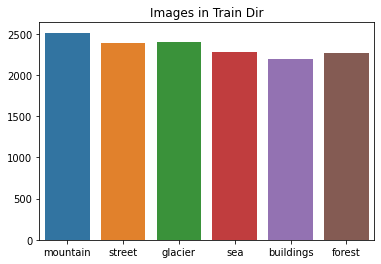

In [10]:
print("total images in train dir: {}".format(sum(train_classes)))
sns.barplot(x=os.listdir(train_dir), y = train_classes).set(title='Images in Train Dir')
plt.show()

In [11]:
# print("total images in test dir: {}".format(sum(test_classes)))
# sns.barplot(x=os.listdir(test_dir), y = test_classes).set(title='Images in Test Dir')
# plt.show()

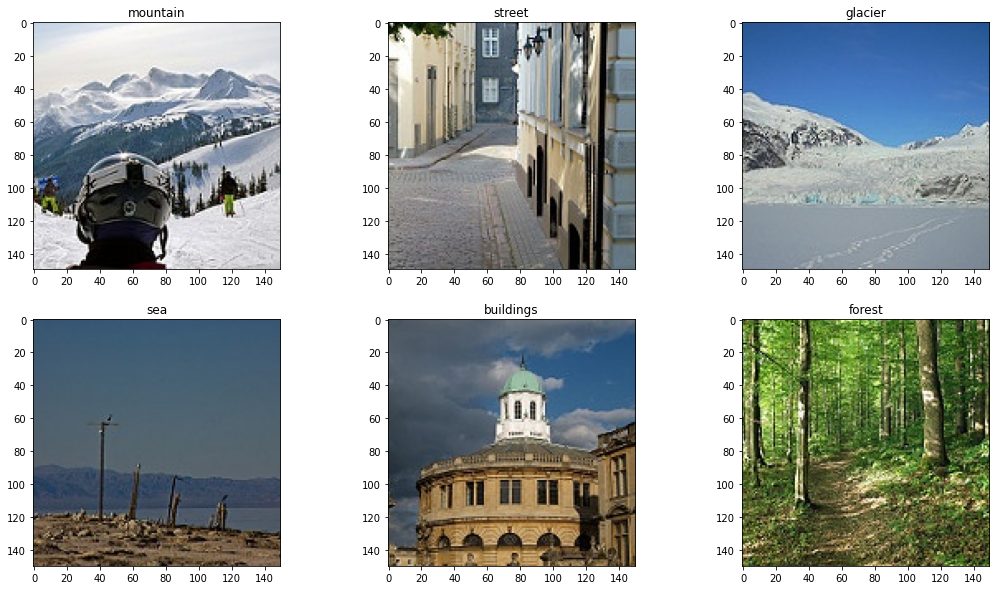

In [12]:
# Show sample images for each classes

fig = plt.figure(figsize = (18,10))

for index in range (len(os.listdir(train_dir))):
  dir = os.path.join(train_dir, os.listdir(train_dir)[index])
  img = cv2.imread(os.path.join(dir, os.listdir(dir)[0]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  ax = fig.add_subplot(2,3,index+1)
  ax.imshow(img)
  ax.set_title(os.listdir(train_dir)[index])

# Data Preprocessing

In [13]:
train_generator = ImageDataGenerator(rescale = 1./255,
                                      rotation_range=20,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      shear_range = 0.2,
                                      zoom_range = 0.2,
                                      fill_mode = 'nearest',
                                      validation_split = 0.2)

# valid_generator = ImageDataGenerator(rescale=1./255)

In [14]:
train_datagen = train_generator.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    target_size= (150,150),
                                                    class_mode = 'categorical',
                                                    subset='training')

test_datagen = train_generator.flow_from_directory(train_dir,
                                                    batch_size = 16,
                                                    target_size= (150,150),
                                                    class_mode = 'categorical',
                                                   subset='validation')

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


# Build and Train Model

In [15]:
model = Sequential()
# model.add(tf.keras.applications.InceptionV3(input_shape=(150,150,3), weights='imagenet', include_top=False ))
model.add(Conv2D(128, 5, input_shape=(150,150,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.5))
model.add(Conv2D(512, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 33, 256)       590080    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 256)      0

In [16]:
callback = EarlyStopping(monitor = 'val_loss',
                        patience = 3,
                        verbose = 1)


In [17]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [18]:
history = model.fit(train_datagen,
          # steps_per_epoch= 128,
          validation_data = test_datagen,
          callbacks = [callback],
          epochs= 50,
          verbose =1)

Epoch 1/50
562/562 [==============================] - 107s 171ms/step - loss: 1.1991 - accuracy: 0.4998 - val_loss: 1.1157 - val_accuracy: 0.5635
Epoch 2/50
562/562 [==============================] - 94s 167ms/step - loss: 0.9766 - accuracy: 0.6126 - val_loss: 0.8772 - val_accuracy: 0.6658
Epoch 3/50
562/562 [==============================] - 94s 168ms/step - loss: 0.8415 - accuracy: 0.6780 - val_loss: 0.7496 - val_accuracy: 0.7322
Epoch 4/50
562/562 [==============================] - 94s 167ms/step - loss: 0.7421 - accuracy: 0.7185 - val_loss: 0.7577 - val_accuracy: 0.7108
Epoch 5/50
562/562 [==============================] - 94s 167ms/step - loss: 0.6732 - accuracy: 0.7524 - val_loss: 0.6836 - val_accuracy: 0.7589
Epoch 6/50
562/562 [==============================] - 94s 167ms/step - loss: 0.6379 - accuracy: 0.7654 - val_loss: 0.6076 - val_accuracy: 0.7785
Epoch 7/50
562/562 [==============================] - 94s 167ms/step - loss: 0.5975 - accuracy: 0.7772 - val_loss: 0.5615 - val_a

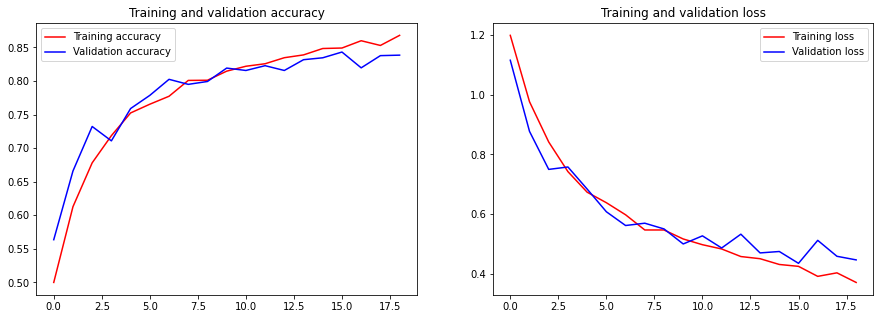

In [19]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


ax1.plot(epochs, acc, 'r', label='Training accuracy')
ax1.plot(epochs, val_acc, 'b', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend(loc=0)


ax2.plot(epochs, loss, 'r', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend(loc=0)


plt.show()

# Save Model

In [22]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)
 
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

114232672